<a href="https://colab.research.google.com/github/ritik007soni/Stock-Trend-Prediction/blob/main/StockTrends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#installing yfinance api to gather all the historical stock data
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


FinTA (Financial Technical Analysis):

Common financial technical indicators implemented in Pandas.
* Simple Moving Average 'SMA'
* Simple Moving Median 'SMM'
* Smoothed Simple Moving Average 'SSMA'
* Exponential Moving Average 'EMA', etc.

In [5]:
pip install finta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import yfinance as yf
import numpy as np
import pandas as Pd
import datetime
from finta import TA
import matplotlib.pyplot as plt

In [9]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

In [28]:
"""
Defining some constants for data mining
"""

NUM_DAYS = 10000     # The number of days of historical data to retrieve
INTERVAL = '1d'     # Sample rate of historical data
symbol = 'TCS.NS'      # Symbol of the desired stock

# List of symbols for technical indicators
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

1995-06-24
[*********************100%***********************]  1 of 1 completed
                 open       high        low      close  Adj Close  volume
Date                                                                     
2002-08-12  38.724998  40.000000  38.724998  39.700001  29.062021  212976
2002-08-13  39.750000  40.387501  38.875000  39.162498  28.668541  153576
2002-08-14  39.250000  39.250000  35.724998  36.462502  26.692032  822776
2002-08-15  36.462502  36.462502  36.462502  36.462502  26.692032       0
2002-08-16  36.275002  38.000000  35.750000  36.375000  26.627981  811856


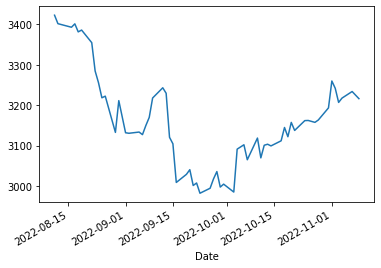

In [39]:
"""
Next we pull the historical data using yfinance
Rename the column names because finta uses the lowercase names
"""

start = (datetime.date.today() - datetime.timedelta( NUM_DAYS ) )
print(start)
end = datetime.datetime.today()

data = yf.download(symbol, start=start, end=end, interval=INTERVAL)
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
print(data.head())

tmp = data.iloc[-60:]
tmp['close'].plot()